In [1]:
import os
import shutil
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

color_key = {'CWUBRG'[i]: (i, c) for i, c in enumerate(['colorless','white','blue','black','red','green'])}
docstring = \
    """
        Docstring

         Parameters
        -------------------
            param : description
         Returns
        -------------------
            return description
    """

In [2]:
cards = pd.read_json('data/cards.json')

In [3]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28469 entries, 0 to 28468
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   object             28469 non-null  object        
 1   id                 28469 non-null  object        
 2   oracle_id          28469 non-null  object        
 3   multiverse_ids     28469 non-null  object        
 4   mtgo_id            21510 non-null  float64       
 5   mtgo_foil_id       16826 non-null  float64       
 6   tcgplayer_id       27598 non-null  float64       
 7   cardmarket_id      26748 non-null  float64       
 8   name               28469 non-null  object        
 9   lang               28469 non-null  object        
 10  released_at        28469 non-null  datetime64[ns]
 11  uri                28469 non-null  object        
 12  scryfall_uri       28469 non-null  object        
 13  layout             28469 non-null  object        
 14  highre

In [4]:
cards.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,loyalty,color_indicator,life_modifier,hand_modifier,content_warning,printed_name,printed_type_line,variation_of,printed_text,flavor_name
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,[435231],65170.0,65171.0,145764.0,301766.0,Siren Lookout,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,0001f1ef-b957-4a55-b47f-14839cdbab6f,ef027846-be81-4959-a6b5-56bd01b1e68a,[472997],78170.0,NaN,198861.0,400134.0,Venerable Knight,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,00020b05-ecb9-4603-8cc1-8cfa7a14befc,d96ac790-428b-4a64-8dbd-6baa73eb6210,[394089],NaN,NaN,95585.0,272052.0,Wildcall,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cards[cards['set'].isin(['m10', 'm12'])]

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,loyalty,color_indicator,life_modifier,hand_modifier,content_warning,printed_name,printed_type_line,variation_of,printed_text,flavor_name
112,card,00dcb25e-764b-47d6-bec4-225aaace77b0,fa3883c7-4fb4-48b9-847b-9a94d1988dd7,[220088],41363.0,41364.0,47699.0,248014.0,Drifting Shade,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,card,0296eaa6-f9fe-4fb8-af9c-04928d99e2e2,f8848065-7075-41d8-82f6-67ace390625a,[238327],41539.0,41540.0,47183.0,247825.0,Peregrine Griffin,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,card,03354b67-7df2-4b4b-a996-a37550e58561,2f5bf099-2e01-4e1c-9ebf-0ce0ac66939e,[189883],32725.0,32726.0,32571.0,21218.0,Centaur Courser,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,card,04c0357a-e98d-4c49-83ad-d7a8ebe7e2d1,e1096a98-a631-43f5-97d8-325001d608b3,[237006],41541.0,41542.0,47551.0,247959.0,Quicksilver Amulet,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642,card,059e8ead-f295-4ca7-a309-6768e6e765cf,dd2bbc90-0474-42b7-afe4-3655a120ab02,[189885],32727.0,32728.0,32770.0,21168.0,Xathrid Demon,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28117,card,fd169064-9c7b-40bd-8be0-a89fcb28ae2f,e766a5eb-684b-4939-b164-6093d15600c9,[220218],41415.0,41416.0,47687.0,248029.0,Amphin Cutthroat,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28180,card,fd90cf36-9841-4adf-b5cb-0a7bf103eb93,0f12aec9-5898-4261-bebd-1b545e0aea68,[236459],41515.0,41516.0,47633.0,247849.0,Mind Unbound,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28198,card,fdbdf96b-e7c5-42e5-9a16-03daafde40af,446a9d7e-9c1a-4e83-8342-2ed5acae2eed,[191598],32629.0,32630.0,32745.0,21122.0,Tome Scour,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28212,card,fddb054f-0617-4afb-8ed1-a067f234f8e7,75a4ddf5-1b3c-4dde-a6e4-4346e46cebf1,[220098],41367.0,41368.0,47636.0,247954.0,Druidic Satchel,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def gather_artwork(cards, filepath='.'):
    """
        Take in a DataFrame of card info from ScryFall.com to
        request and save cropped card artwork
        
         Parameters
        -------------------
            cards: A Pandas DataFrame of mtg card data
            
         Returns
        -------------------
            None
    """
    
    total = cards.shape[0]
    
    for i, row in cards.iterrows():
        if i % 100 == 0:
            print(f"{i} of {total} gathered.")
        try:
            fp = f"{filepath}/art/{row['set']}/"  # Directory location
            fn = f"/{row['id']}.jpg"  # File name
            link = row['image_uris']['art_crop']  # Link to request
            s = f"({i}/{total}) {row['name']}"
    
        except:
            print(row['name'] + ' Failed.')
            continue
    
        # Skip if this file already exists
        if os.path.isfile(fp+fn): continue
        
        # Make request
        response = requests.get(link, stream=True)
        # Save image if request was successful
        if response.status_code == 200:
            # Create destination directory if it doesn't exist
            if not os.path.isdir(fp): os.makedirs(fp)
            # Save image
            with open(fp + fn, 'wb') as f:
                response.raw.decode_content = True
                shutil.copyfileobj(response.raw, f)

def remove_lands(cards):
    """
        Remove lands from a DataFrame of Scryfall.com card data
        -------------------
            cards : A Pandas DataFrame of mtg card data
         Returns
        -------------------
            A Pandas DataFrame of mtg card data with the lands removed
    """
    return cards[~cards['type_line'].apply(lambda x: 'Land' in x)]

def mono_color_cards(cards):
    """
        Take in a DataFrame of card info from ScryFall.com and returns
        only the mono-colored cards
        
         Parameters
        -------------------
            cards: A Pandas DataFrame of mtg card data
            
         Returns
        -------------------
            A Pandas DataFrame of mtg card data for only mono-color cards
    """
    mask = cards['colors'].apply(lambda x: len(x) < 2 if type(x) == list else False)
    return cards[mask]

C    5442
W    4002
U    3929
B    3955
R    3948
G    3967
Name: colors, dtype: int64

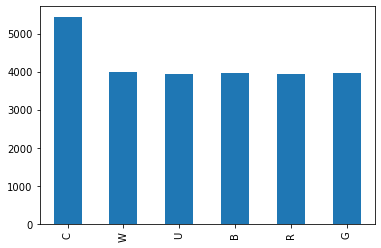

In [7]:
mono = mono_color_cards(cards)
counts = mono['colors'].apply(lambda x: x[0] if x else 'C').value_counts()
counts = counts.reindex(color_key.keys())
counts.plot(kind='bar')
counts

C    3125
W    4002
U    3929
B    3955
R    3948
G    3965
Name: colors, dtype: int64

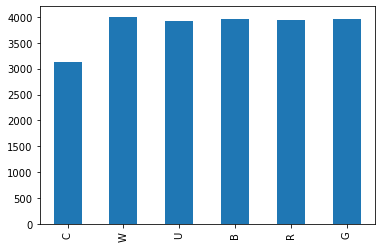

In [8]:
mono = remove_lands(mono)
counts = mono['colors'].apply(lambda x: x[0] if x else 'C').value_counts()
counts = counts.reindex(color_key.keys())
counts.plot(kind='bar')
counts

In [9]:
c = mono_color_cards(cards[cards['set'].isin(['m12'])])
# gather_artwork(c)
card = c.iloc[0]
fp = f"/home/jovyan/data/art/{card['set']}/{card['id']}.jpg"
raw_image = tf.io.read_file(fp)
image = tf.image.decode_jpeg(raw_image)

In [10]:
image.shape

TensorShape([452, 616, 3])

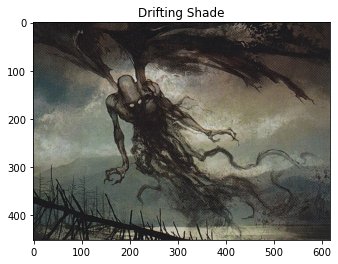

In [11]:
def plot_img(image):
    fig, ax = plt.subplots()
    ax.set_title(card['name'])
    plt.imshow(image)

plot_img(image)

In [12]:
def plot_channels(fp, name='Full Color'):
    raw_image = tf.io.read_file(fp)
    image = tf.image.decode_jpeg(raw_image)
    fig, axs = plt.subplots(1, 4, figsize=(16,8))
    axs[0].imshow(image)
    axs[0].set_title(name)
    for i in range(1, 4):
        axs[i].imshow(image[:, :, i-1], cmap=[plt.cm.Reds, plt.cm.Greens, plt.cm.Blues][i-1])
        axs[i].set_title('{} Channel'.format(['Red', 'Green', 'Blue'][i-1]))

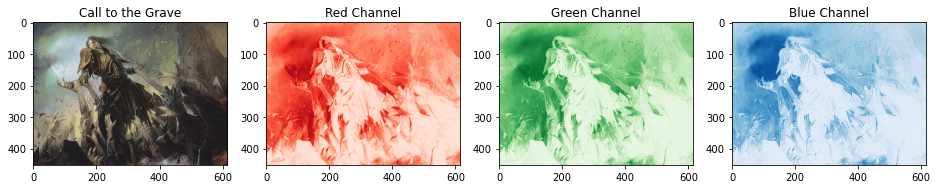

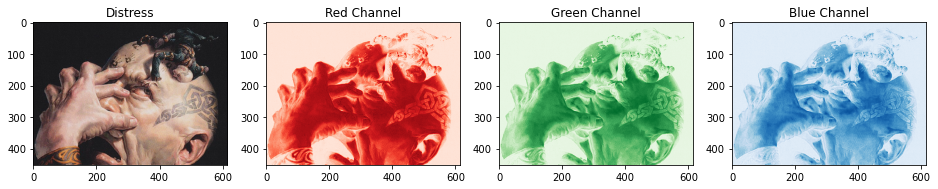

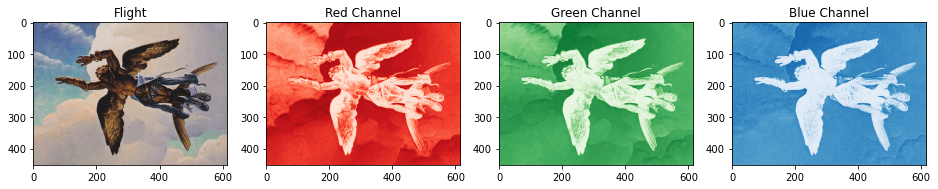

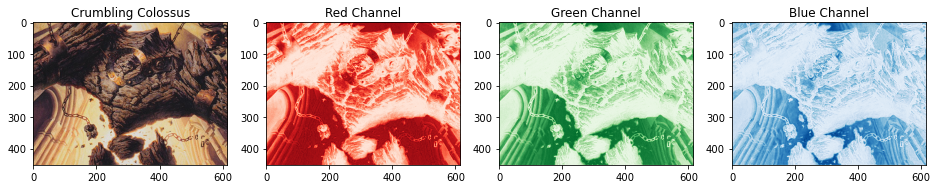

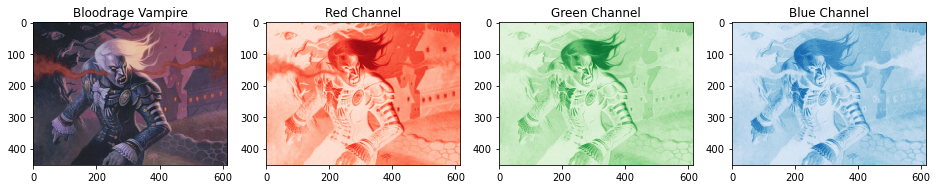

In [13]:
for n in np.random.choice(c.shape[0], 5):
    card = c.iloc[n]
    fp = f"/home/jovyan/data/art/{card['set']}/{card['id']}.jpg"
    plot_channels(fp, card['name'])
    plt.show()

In [14]:
def generate_flow_df(cards):
    paths = [f"{card[0]}/{card[1]}.jpg" for card in cards[['set', 'id']].values]
    targets = cards['colors'].apply(lambda x: x[0] if x else 'C')
    return pd.DataFrame({'path': paths, 'target': targets})

In [15]:
generate_flow_df(c)

,path,target
112,m12/00dcb25e-764b-47d6-bec4-225aaace77b0.jpg,B
291,m12/0296eaa6-f9fe-4fb8-af9c-04928d99e2e2.jpg,W
538,m12/04c0357a-e98d-4c49-83ad-d7a8ebe7e2d1.jpg,C
784,m12/06cc574a-f687-4e41-b0a0-62a0eedea7c2.jpg,U
1064,m12/094c839e-0aea-4754-af37-edf6292623e1.jpg,W
...,...,...
27594,m12/f82e6a81-6a45-45f9-829d-332859a32257.jpg,W
28061,m12/fc9a50af-ca3e-461a-9dcb-444f56284165.jpg,R
28117,m12/fd169064-9c7b-40bd-8be0-a89fcb28ae2f.jpg,U
28180,m12/fd90cf36-9841-4adf-b5cb-0a7bf103eb93.jpg,U


In [16]:
train_df, test_df = train_test_split(generate_flow_df(c), test_size=0.2)
train_idg = keras.preprocessing.image.ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)
test_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [17]:
parent_dir = '/home/jovyan/data/art/'
target_size = (224, 224)
batch_size = 8

train_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory = parent_dir,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19
)

valid_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=parent_dir,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19
)

test_gen = test_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=parent_dir,
    x_col='path',
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 74 validated image filenames belonging to 6 classes.
Found 18 validated image filenames belonging to 6 classes.
Found 24 validated image filenames.


In [18]:
input_shape = target_size + (3,)
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(6, activation='softmax'))

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.fit(
    train_gen,
    validation_data=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_steps=valid_gen.n//valid_gen.batch_size,
    epochs=10
)

Epoch 1/10
9/9 [==============================] - 2s 217ms/step - loss: 22.4175 - accuracy: 0.2125 - val_loss: 16.3922 - val_accuracy: 0.1875
Epoch 2/10
9/9 [==============================] - 2s 169ms/step - loss: 11.7867 - accuracy: 0.3070 - val_loss: 5.3560 - val_accuracy: 0.1250
Epoch 3/10
9/9 [==============================] - 2s 180ms/step - loss: 4.9044 - accuracy: 0.2953 - val_loss: 2.3564 - val_accuracy: 0.1875
Epoch 4/10
9/9 [==============================] - 2s 169ms/step - loss: 2.1419 - accuracy: 0.2266 - val_loss: 2.0806 - val_accuracy: 0.3125
Epoch 5/10
9/9 [==============================] - 2s 181ms/step - loss: 1.7397 - accuracy: 0.4015 - val_loss: 1.6952 - val_accuracy: 0.1875
Epoch 6/10
9/9 [==============================] - 2s 169ms/step - loss: 1.5663 - accuracy: 0.2991 - val_loss: 1.1438 - val_accuracy: 0.6250
Epoch 7/10
9/9 [==============================] - 2s 168ms/step - loss: 1.4041 - accuracy: 0.3766 - val_loss: 1.2574 - val_accuracy: 0.6875
Epoch 8/10
9/9 [=

In [21]:
score = model.evaluate(valid_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


3/3 [==============================] - 0s 68ms/step - loss: 1.7762 - accuracy: 0.4444
Test loss: 1.7761812210083008
Test accuracy: 0.4444444477558136


In [22]:
filenames = test_gen.filenames
predict = model.predict(test_gen, steps=len(filenames))
filenames

['m12/5ac2dbbc-8bf4-45fd-a5c1-7597c885fc6b.jpg',
 'm12/87352716-4cf6-4b2f-bb0a-b7aafae64478.jpg',
 'm12/589524db-68b9-46eb-a8ab-55986f37fbed.jpg',
 'm12/d56c82ad-5eb1-4653-8f02-e9bb1f6f3154.jpg',
 'm12/125c5cff-d4e9-4655-9cc5-3ce21e577569.jpg',
 'm12/79e42ead-df6e-4181-ae2b-a2abfc3f1d7c.jpg',
 'm12/1c71eb81-a077-4c85-a4ce-4ad664486bee.jpg',
 'm12/628213e9-bde9-43fd-a0d9-8c7fb17be879.jpg',
 'm12/2cb62846-c5da-4c7c-b0d7-9b677dce68d1.jpg',
 'm12/094c839e-0aea-4754-af37-edf6292623e1.jpg',
 'm12/32c8d6ed-4764-433b-9617-363e46e5b250.jpg',
 'm12/fc9a50af-ca3e-461a-9dcb-444f56284165.jpg',
 'm12/93c8159b-8c1d-480a-b517-dbd67bba1838.jpg',
 'm12/bb0a0d33-8862-433b-a078-82472e5f9af0.jpg',
 'm12/76f69b92-7435-4aa8-9d90-89ea078befb1.jpg',
 'm12/a258a235-086e-429b-9ac1-3178f902658b.jpg',
 'm12/b09140f6-fa75-4bee-9ca0-3a71cd2b5a7b.jpg',
 'm12/6af53d7f-7f02-4c35-b6f4-7365d121ba54.jpg',
 'm12/4560ee1a-1076-4ec5-a177-55ffe12e2165.jpg',
 'm12/04c0357a-e98d-4c49-83ad-d7a8ebe7e2d1.jpg',
 'm12/3b781626-f4ce-

In [23]:
p = ['CWUBRG'[c] for c in predict.argmax(axis=1)]
k = [f.split('/')[1].replace('.jpg','') for f in filenames]
pred_df = pd.DataFrame({'id': k, 'prediction': p})
pred_df['actual'] = test_df['target'].values
pred_df
# cards['id'].apply(lambda x: x in k)

,id,prediction,actual
0,5ac2dbbc-8bf4-45fd-a5c1-7597c885fc6b,W,C
1,87352716-4cf6-4b2f-bb0a-b7aafae64478,W,C
2,589524db-68b9-46eb-a8ab-55986f37fbed,W,C
3,d56c82ad-5eb1-4653-8f02-e9bb1f6f3154,W,G
4,125c5cff-d4e9-4655-9cc5-3ce21e577569,W,B
5,79e42ead-df6e-4181-ae2b-a2abfc3f1d7c,R,C
6,1c71eb81-a077-4c85-a4ce-4ad664486bee,R,W
7,628213e9-bde9-43fd-a0d9-8c7fb17be879,W,U
8,2cb62846-c5da-4c7c-b0d7-9b677dce68d1,W,B
9,094c839e-0aea-4754-af37-edf6292623e1,W,W


In [25]:
def plot_conf_matrix(true, pred, ax=None):
    
    # Get Confusion Matrix
    cm = confusion_matrix(true, pred)
    
    # Set up axis
    ax = ax if ax else plt.gca()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(6))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(color_key.keys())
    ax.set_yticklabels(color_key.keys())
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
        
    # Plot values
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    
    plt.show()

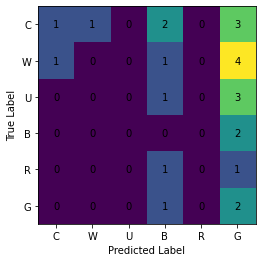

In [26]:
plot_conf_matrix(pred_df['actual'], pred_df['prediction'])
